# **CIS 4190/5190 Homework 3 - Fall 2024**

**Before starting, you must click on the "Copy To Drive" option in the top bar. Go to File --> Save a Copy to Drive. This is the master notebook so <u>you will not be able to save your changes without copying it </u>! Once you click on that, make sure you are working on that version of the notebook so that your work is saved**

# Libraries

In [ ]:
# Restart the runtime after running this cell everytime you open the notebook
#!pip install pandas==1.1.5

In [ ]:
import random
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from numpy.linalg import *
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import preprocessing
from scipy.spatial import distance

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
from PIL import Image

np.random.seed(42)  # Do Not change this line

import base64

In [ ]:
# For autogreader only, do not modify this cell.
# True for Google Colab, False for autograder
NOTEBOOK = (os.getenv('IS_AUTOGRADER') is None)
if NOTEBOOK:
    print("[INFO, OK] Google Colab.")
else:
    print("[INFO, OK] Autograder.")

[INFO, OK] Google Colab.


# **PennGrader Setup**
First, you'll need to set up the PennGrader, an autograder we are going to use throughout the semester. The PennGrader will automatically grade your answer and provide you with an instant feedback. Unless otherwise stated, you can resubmit up to a reasonable number of attempts (e.g. 100 attemptes per day). **We will only record your latest score in our backend database**.

After finishing each homework assignment, you must submit your iPython notebook to gradescope before the homework deadline. Gradescope will then retrive and display your scores from our backend database.

In [ ]:
%%capture
!pip install penngrader-client

In [ ]:
%%writefile student_config.yaml
grader_api_url: 'https://23whrwph9h.execute-api.us-east-1.amazonaws.com/default/Grader23'
grader_api_key: 'flfkE736fA6Z8GxMDJe2q8Kfk8UDqjsG3GVqOFOa'

Writing student_config.yaml


In [ ]:
from penngrader.grader import *

In [ ]:
#PLEASE ENSURE YOUR PENN-ID IS ENTERED CORRECTLY. IF NOT, THE AUTOGRADER WON'T KNOW WHO
#TO ASSIGN POINTS TO YOU IN OUR BACKEND
STUDENT_ID = 41855518          # YOUR PENN-ID GOES HERE AS AN INTEGER#

Run the following cell to initialize the autograder. This autograder will let you submit your code directly from this notebook and immediately get a score.

**NOTE:** Remember we store your submissions and check against other student's submissions... so, not that you would, but no cheating.

In [ ]:
#GRADER TODO
grader = PennGrader('student_config.yaml', 'cis5190_fall24_HW3', STUDENT_ID, STUDENT_ID)

PennGrader initialized with Student ID: 41855518

Make sure this correct or we will not be able to store your grade


In [ ]:
# Serialization code needed by the autograder
import inspect, sys
from IPython.core.magics.code import extract_symbols

def new_getfile(object, _old_getfile=inspect.getfile):
    if not inspect.isclass(object):
        return _old_getfile(object)

    # Lookup by parent module (as in current inspect)
    if hasattr(object, '__module__'):
        object_ = sys.modules.get(object.__module__)
        if hasattr(object_, '__file__'):
            return object_.__file__

    # If parent module is __main__, lookup by methods (NEW)
    for name, member in inspect.getmembers(object):
        if inspect.isfunction(member) and object.__qualname__ + '.' + member.__name__ == member.__qualname__:
            return inspect.getfile(member)
    else:
        raise TypeError('Source for {!r} not found'.format(object))
inspect.getfile = new_getfile

def grader_serialize(obj):
    cell_code = "".join(inspect.linecache.getlines(new_getfile(obj)))
    class_code = extract_symbols(cell_code, obj.__name__)[0][0]
    return class_code

## Datasets
Next, we will download the dataset from Google Drive to your local runtime. After successful download, you may verify that all datasets are present in your colab instance.

- [observations.csv](https://drive.google.com/file/d/1RvNTrL147Cx90ABv4IfXcexaRyHB-U-e/view?usp=sharing)
- [test_student.csv](https://drive.google.com/file/d/1EjQ3Jy5q25GaxeNKh4ahtsLgHEyW3tUj/view?usp=sharing)


#### Acknowledgement
Dataset obtained from kaggle.com [Hourly Weather Surface - Brazil (Southeast region)](https://www.kaggle.com/PROPPG-PPG/hourly-weather-surface-brazil-southeast-region/metadata )

In [ ]:
if NOTEBOOK:
  import gdown
  if not os.path.exists("observations.csv"):
    !gdown --id 1RvNTrL147Cx90ABv4IfXcexaRyHB-U-e
  if not os.path.exists("test_student.csv"):
    !gdown --id 1Z0I6iylDgTk2OKuKDaQVR9I1aJvgRsn_


/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1RvNTrL147Cx90ABv4IfXcexaRyHB-U-e
To: /content/observations.csv
100% 13.5M/13.5M [00:00<00:00, 39.5MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Z0I6iylDgTk2OKuKDaQVR9I1aJvgRsn_
To: /content/test_student.csv
100% 277k/277k [00:00<00:00, 8.11MB/s]


## **NOTE 1. Results of sections marked as "manually graded" should be submitted along with the written homework solutions.**

## **NOTE 2. If you are running into a `__builtins__' error, it's likely because you're using a function call of the form numpy.ndarray.mean(), like a.mean(). This does not play nice with PennGrader unfortunately. Please use the function call numpy.mean(a) instead.**

#**1. [25 pts, 15 autograded, 10 manually graded] K-means Clustering**

We will implement the k-means clustering algorithm using the Breast Cancer dataset. As with all unsupervised learning problems, our goal is to discover and describe some hidden structure in unlabeled data. The k-means algorithm, in particular, attempts to determine how to separate the data into <em>k</em> distinct groups over a set of features ***given that we know (are provided) the value of k***.

Knowing there are <em>k</em> distinct 'classes' however, doesn't tell anything about the content/properties within each class. If we could find samples that are representative of each of these *k* groups, then we could label the rest of the data based on how similar they are to each of the prototypical samples. We will refer to these representatives as the centroids (cluster centers) that correspond to each cluster.

## **1.1. Import the dataset**


In [ ]:
from sklearn.datasets import load_breast_cancer
cancer_dataset = load_breast_cancer()

## STUDENT TODO START:
"""
First load the dataset X from cancer_dataset.
X -  (m, n) -> m x n matrix where m is the number of training points = 569 and n is the no of features = 30
"""

X = cancer_dataset.data
y = cancer_dataset.target

## STUDENT TODO END

In [ ]:
X.shape

(569, 30)

In [ ]:
y.shape

(569,)

## **1.2. [12 pts] K-means clustering implementation**

We will first implement a class for k-means clustering.<br>
These are the main functions: <br>
- `__init__`: The initialiser/constructor (This is implemented for you)
- `fit`: Entrypoint function that takes in the dataset (X) as well as centroid initialisations and returns:
    - the cluster labels for each row (data point) in the dataset
    - list of centroids corresponding to each cluster
    - no of iterations taken to converge.

Inside fit() function, you will need to implement the actual kmeans functionality. <br>
The K-means process you should follow is listed below:
1. Initialize each of the k centroids to a random datapoint if initialisation is not provided.
2. Update each datapoint's cluster to that whose *centroid* is closest
3. Calculate the new *centroid* of each cluster
4. Repeat the previous two steps until no centroid value changes. Make sure you break out of the loop reagrdless of whether you converged or not once max iterations are reached.

To help streamline this process, three helper functions have been defined for you in the KMeans class \
- compute_distance(): use for step-2 above
- find_closest_cluster(): use for step-2 above
- compute_centroid(): use for step-3 above


In [ ]:
class KMeans:
    '''Implementing Kmeans clustering'''

    def __init__(self, n_clusters, max_iter=1000):
        self.n_clusters = n_clusters
        self.max_iter = max_iter

    def compute_centroids(self, X, clusters):
        """
        Computes new centroids positions given the clusters

        INPUT:
        X - m by n matrix, where m is the number of training points
        clusters -  m dimensional vector, where m is the number of training points
                    At an index i, it contains the cluster id that the i-th datapoint
                    in X belongs to.

        OUTPUT:
        centroids - k by n matrix, where k is the number of clusters.
        """
        centroids = np.zeros((self.n_clusters, X.shape[1]))
        ## STUDENT TODO START:
        # Compute the average of each clusters and assign to the corresponding centroids
        for k in range (self.n_clusters):
            points_in_cluster = X[clusters == k]

            if len(points_in_cluster) > 0:
                centroids[k] = np.mean(points_in_cluster, axis=0)

        ## STUDENT TODO END
        return centroids

    def compute_distance(self, X, centroids):
        """
        Computes the distance of each datapoint in X from the centroids of all the clusters

        INPUT:
        X - m by n matrix, where m is the number of training points
        centroids - k by n matrix, where k is the number of clusters

        OUTPUT:
        dist - m by k matrix, for each datapoint in X, the distances from all the k cluster centroids.

        """
        dist = np.zeros((X.shape[0], self.n_clusters))
        ## STUDENT TODO START:
        # Calculate the distance of each data point from the centroid
        for i in range(self.n_clusters):
            dist[:, i] = np.linalg.norm(X - centroids[i], axis=1)

        ## STUDENT TODO END
        return dist

    def find_closest_cluster(self, dist):
        """
        Finds the cluster id that each datapoint in X belongs to

        INPUT:
        dist - m by k matrix, for each datapoint in X, the distances from all the k cluster centroids.

        OUTPUT:
        clusters - m dimensional vector, where m is the number of training points
                    At an index i, it contains the cluster id that the i-th datapoint
                    in X belongs to.

        """
        clusters = np.zeros(dist.shape[0])
        ## STUDENT TODO START:
        # Find the closest cluster for each datapoint
        for i in range(dist.shape[0]):
            clusters[i] = np.argmin(dist[i])


        ## STUDENT TODO END ##
        return clusters

    def fit(self, X, init_centroids=None):
        """
        Fit KMeans clustering to given dataset X.

        INPUT:
        X - m by n matrix, where m is the number of training points
        init_centroids (optional) - k by n matrix, where k is the number of clusters

        OUTPUT:
        clusters - m dimensional vector, where m is the number of training points
                    At an index i, it contains the cluster id that the i-th datapoint
                    in X belongs to.
        centroids - k by n matrix, where k is the number of clusters.
                    These are the k cluster centroids, for cluster ids 0 to k-1
        iters_taken - total iterations taken to converge. Should not be more than max_iter.

        """
        # Fix random seed. Do not change this!
        np.random.seed(111)

        ## STUDENT TODO START:
        # Initialise centroids to random points in the dataset if not provided (i.e. None)
        if init_centroids is None:
            init_centroids = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]

        self.centroids = init_centroids


        # Iterate until kmeans converges or max_iters is reached. In each iteration:
        #  - Update each datapoint's cluster to that whose *centroid* is closest
        #  - Calculate the new *centroid* of each cluster
        #  - Repeat the previous two steps until no centroid value changes.
        iters_taken = 0
        for _ in range(self.max_iter):
            dist = self.compute_distance(X, self.centroids)
            self.clusters = self.find_closest_cluster(dist)
            new_centroids = self.compute_centroids(X, self.clusters)
            if np.all(self.centroids == new_centroids):
                break

            self.centroids = new_centroids
            iters_taken+=1

        ## STUDENT TODO END
        return self.clusters, self.centroids, iters_taken

In [ ]:
# test case centroids should be aroudn (1.5,1.5) and (4.5,4.5)
points = []
result = []
random.seed(0)
for _ in range(500):
  x = random.random()*3
  y = random.random()*3
  points.append((x,y))
  result.append(0)
for _ in range(500):
  x = random.random()*3 + 3
  y = random.random()*3 + 3
  points.append((x,y))
  result.append(1)
clf = KMeans(2)
points = np.asarray(points)

In [ ]:
#test for sanity check
def test_compute_centroids():
  clf = KMeans(2)
  centroid_p = clf.compute_centroids(np.array(points),np.array(result))
  centroid_r = [[1.5185255, 1.45970038],
 [4.51568108,4.54138552]]
  assert(np.linalg.norm(centroid_p - np.array(centroid_r)) <= 1e-2 )
test_compute_centroids()

In [ ]:
# PennGrader Grading Cell
grader.grade(test_case_id = 'test_compute_centroids', answer = grader_serialize(KMeans))

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [ ]:
def test_distance():
    centroid_r = [[1.5185255, 1.45970038],
      [4.51568108,4.54138552]]
    clf = KMeans(2)
    distance = clf.compute_distance(np.array(points),np.array(centroid_r))
    distance_for_0 = [1.30098366, 3.01191447]
    assert(np.linalg.norm(distance_for_0-distance[0]) <= 1e-2)
test_distance()

In [ ]:
# PennGrader Grading Cell
grader.grade(test_case_id = 'test_distance', answer = grader_serialize(KMeans))

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [ ]:
def test_find_clusters():
  centroid_r = [[1.5185255, 1.45970038],
      [4.51568108,4.54138552]]
  clf = KMeans(2)
  distance = clf.compute_distance(np.array(points),np.array(centroid_r))
  cluster = clf.find_closest_cluster(distance)
  assert(cluster[0] == 0)
test_find_clusters()

In [ ]:
# PennGrader Grading Cell
grader.grade(test_case_id = 'test_find_clusters', answer = grader_serialize(KMeans))

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [ ]:
def test_fit():
  clf = KMeans(2)
  clusters, centroids, _ = clf.fit(np.array(points),np.array([[1,1],[4,4]]))
  centroid_r = [[1.5185255, 1.45970038],
      [4.51568108,4.54138552]]
  assert(np.linalg.norm(centroids - np.array(centroid_r)) <= 1e-2 )
  assert(sum(np.array(clusters)-np.array(result)) == 0)
test_fit()

In [ ]:
# PennGrader Grading Cell
grader.grade(test_case_id = 'test_fit', answer = grader_serialize(KMeans))

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## **1.3. [3 pts] Compute distortion**

As you may have noticed already, one big question still remains. How do we know what value of k to choose?

One way to decide on a value for k is to run k-means and plot the distortion (sum of squared error based on the Euclidean distance). From that we can find the "elbow of the graph" that indicates the best tradeoff between number of clusters and corresponding distortion.

In the function `test_cluster_size`,  iterate over possible cluster sizes from 2 to a `max_cluster` (inclusive) value. For each *k*, run k-means and calculate its distortion.

In [ ]:
def test_cluster_size(X, max_k):
    """
    Iterates over possible cluster from 2 to max_k, running k-means and calulating distortion.

    INPUT:
    X - m by n matrix, where m is the number of training points
    max_k - the maximum number of clusters to consider

    OUTPUT:
    scores - a list of scores, that contains the distortion for k = 2 to max_k, in order.
    """
    scores = [0] * (max_k-1)
    ## STUDENT TODO START:
    # Run KMeans for each cluster, analyze at which point the distortion starts decreasing more
    # slowly (also called calculating the elbow method)
    for i in range(2, max_k+1):
        clf = KMeans(i)
        _, centroids, _ = clf.fit(X)
        dist = clf.compute_distance(X, centroids)
        scores[i-2] = np.sum(np.min(dist, axis=1))

    ## STUDENT TODO END
    return scores

In [ ]:
def test_test_cluster_size():
  scores = test_cluster_size(np.array(points),5)
  assert(np.argmax(scores) == 0)
test_test_cluster_size()

In [ ]:
# PennGrader Grading Cell
max_k = 20
scores = test_cluster_size(X, max_k)
grader.grade(test_case_id = 'test_test_cluster_size', answer = scores)

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## **1.4. [3 pts, manually graded] Plot distortion vs. k (without feature scaling)**

Plot distortion vs. different k values by using the function we just wrote on dataset X and add it in the written report. Use max_k = 20. Determine the best k value from this plot and also mention it in the written report. Make sure your plot has axes labels, legend and title.

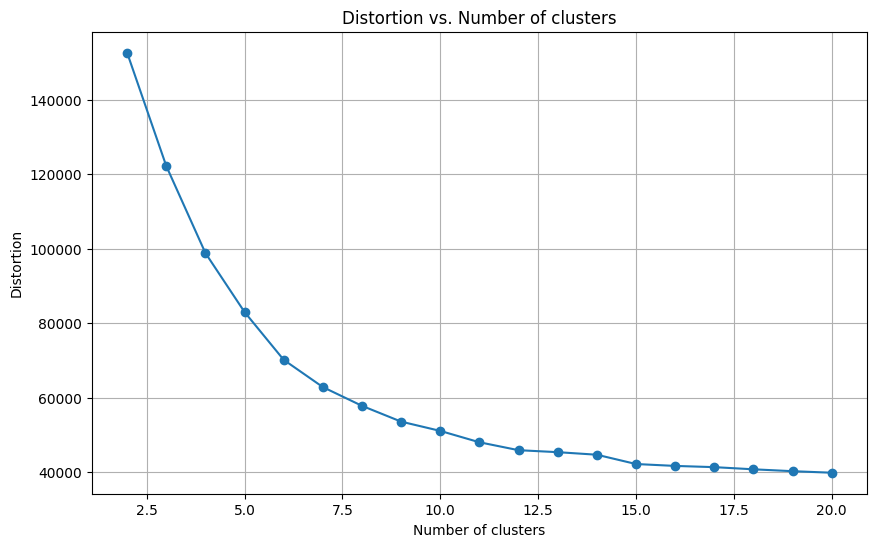

In [ ]:
## STUDENT TODO START:
# Plot distortion vs. k values
plt.figure(figsize=(10, 6))
plt.plot(range(2, max_k+1), scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Distortion vs. Number of clusters')
plt.grid()
plt.show()

## STUDENT TODO END

## **1.5. [3 pts, manually graded] Plot distortion vs. k (with feature scaling)**

What we just did was running k-means clustering over the dataset X without any feature scaling. This time, we will rescale each feature to the standard range of (0,1) before passing it to k-means and computing the distortion.

Use `sklearn.preprocessing.MinMaxScaler` ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)) and scale the dataset X before passing it to the `test_cluster_size` function. As before, plot distortion vs. different k values and add it in the written report. Use max_k = 20. Determine the best k value from this plot and also mention it in the written report. Make sure your plot has axes labels, legend and title.

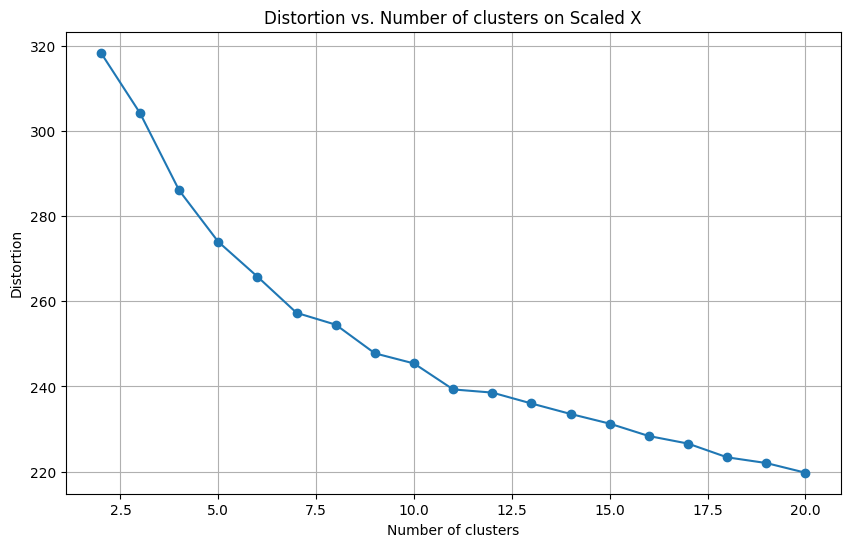

In [ ]:
## STUDENT TODO START
# Use min-max scaler to scale the dataset

mms = preprocessing.MinMaxScaler()
X_scaled = mms.fit_transform(X)

# Test cluster size with the scaled X features and max k
scores_scaled = test_cluster_size(X_scaled, max_k)

# Plot the distortion values
plt.figure(figsize=(10, 6))
plt.plot(range(2, max_k+1), scores_scaled, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Distortion vs. Number of clusters on Scaled X')
plt.grid()
plt.show()

## STUDENT TODO END

## **1.6. [4 pts, manually graded] Comments**

Answer these questions in the written report.

1. Why do you get different results with and without feature scaling?
2. Should you scale the features before fitting k-means? Why or why not?

# **2. [18 pts, 2 autograded, 16 manually graded] Principal Component Analysis**

## **2.1. [8 pts, manually graded] Exploring Effects of Different Princple Components in Linear Regression**
We have introduced you a way of dimension reduction, Principal Component Analysis, in class. Now, we would like to ask you to apply PCA from sklearn on the breast cancer dataset to observe its performance and interpret the major components.

In order to better compare the effects of PCA, we load the labels from the dataset.

Then, we will evaluate the performances of raw dataset and various numbers of pca components on LinearRegression classifier.

In the section, you are asked to draw a plot of test accuracies vs number of different principle components. The detailed instructions are included in the following cells.

Remember to **attach the plot** in your written submission, and also **make comments** about what you observe, explain the reason behind the trend, and what conclusion you could draw from the graph.

In [ ]:
# load the label from the dataset, which is a binary label 0/1 representing whether the cancer is benign or malignant

## STUDENT TODO START
# Load the dataset labels
X = cancer_dataset.data
y = cancer_dataset.target

## STUDENT TODO END

In [ ]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,

Accuracy on test set:  0.9521276595744681


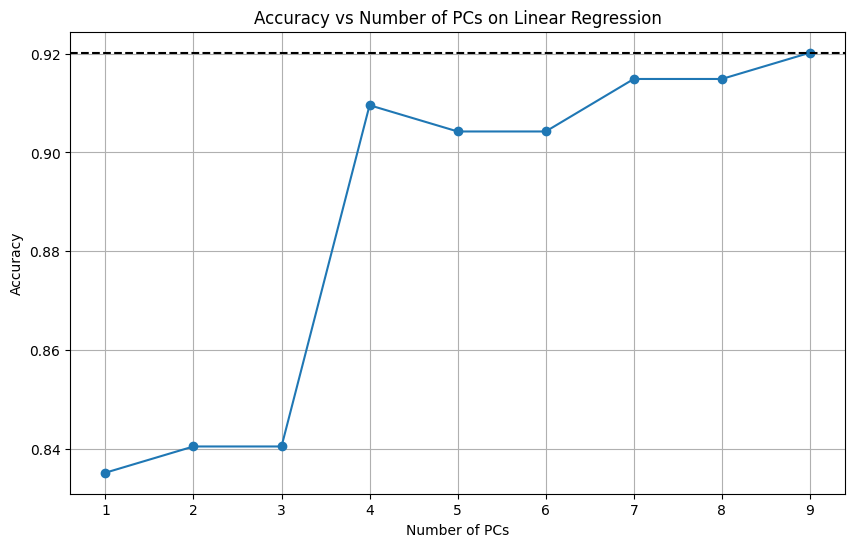

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

## STUDENT TODO START:
# Step 1: split the data into train and test set by a test_size of 0.33.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# Step 2: Train a linear regression model using train set and predict on the test set.
# As the labels are binary, we should cast the predictions into binary labels as well. (Set predictions >=0.5 as 1)
lr = LinearRegression()
lr.fit(X_train, y_train)


y_test_pred = lr.predict(X_test)
final_y_test_pred = (y_test_pred >= 0.5).astype(int)

# You might want to print out accuracy scores here
print("Accuracy on test set: ", np.mean(final_y_test_pred == y_test))


# Step 3: Iterate the number of components from 1 to 10 (exclusive).
# For each number of PCs, we are training a linear regression model and save its accuracy on the test set following the same style as above.
# Remeber to only fit the train set and not the test set.
# You might want to store your accuracies in a list

accuracies = []
for i in range(1, 10):
	pca = PCA(n_components=i)
	X_train_pca = pca.fit_transform(X_train)
	X_test_pca = pca.transform(X_test)

	lr = LinearRegression()
	lr.fit(X_train_pca, y_train)
	y_test_pred = lr.predict(X_test_pca)
	final_y_test_pred = (y_test_pred >= 0.5).astype(int)

	accuracies.append(np.mean(final_y_test_pred == y_test))

# Step 4: Make a plot to compare accuracy vs number of PCs on Linear Regression for the test set.
# Add a black, dashed line for the test accuracy of linear regression by feeding the raw input data.
# Remeber to add x, y labels and title to your plot, and comment on your observations.

plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), accuracies, marker='o', label='PCA')
plt.axhline(np.mean(final_y_test_pred == y_test), color='black', linestyle='--', label='Raw Data')
plt.xlabel('Number of PCs')
plt.ylabel('Accuracy')
plt.grid()
plt.title('Accuracy vs Number of PCs on Linear Regression')
plt.show()

## STUDENT TODO END

## **2.2. [5 pts] Understanding PCA**

### **2.2.1 [2 pts, autograded] Explained Ratio of PCA**
Given a threshold of explained ratio (0 < ratio < 1), compute the number of required PCs to reach the threshold.

In [ ]:
def select_n_principal_components(data, variation):
  ## STUDENT TODO START:
  # Run PCA on n number of components
  # Analyze the explained variance ratios
  # If adding the next component's explained variance doesn't exceed
  # the target variation, add the component's explained variance
  # Return n, where n is the number of components
  pca = PCA()
  pca.fit(data)

  cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

  n_components = np.argmax(cumulative_variance >= variation) + 1

  return n_components

  ## STUDENT TODO END

In [ ]:
# PennGrader Grading Cell
student_ans = [select_n_principal_components(cancer_dataset['data'], 0.98), select_n_principal_components(cancer_dataset['data'], 0.99)]
grader.grade(test_case_id = 'test_select_n_principal_components', answer = student_ans)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### **2.2.2 [3 pts, manually graded] Composition of PCA**
In this section, we ask you to understand which features specifically in the dataset contribute to the important PCs. We ask that you select the best number of principle components you got from previous part and analyze its composition (as there are multiple components contributing to each PC, you only need to specify the **top three** features that are explained by these PCs together).

In [ ]:
## STUDENT TODO START
# Run PCA with a set number of components
# Analyze the composition and pick the top three features

variation_threshold = 0.98

n_components = select_n_principal_components(X, variation_threshold)

pca = PCA(n_components = n_components)

pca.fit(X)

components = pca.components_

total_contributions = np.sum(np.abs(components), axis=0) #most magnitude is most contribution

top_3_feature_indices = np.argsort(total_contributions)[-3:][::-1]

feature_names = list(cancer_dataset.feature_names)

top_3_features = [feature_names[i] for i in top_3_feature_indices]

print(top_3_features)

## STUDENT TODO END

['worst area', 'mean area', 'area error']


## **2.3. [5 pts, manually graded] PCA and KMeans**
We first run PCA on the dataset for visualisation in 2D space. Note that k-means is actually being fit on the entire feature set.

Next, call your k-means class on the dataset X and obtain the clusters. Make sure to populate the "clusters" variable here. We have provided the plotting code for you.

**Add these plots in the written report.**

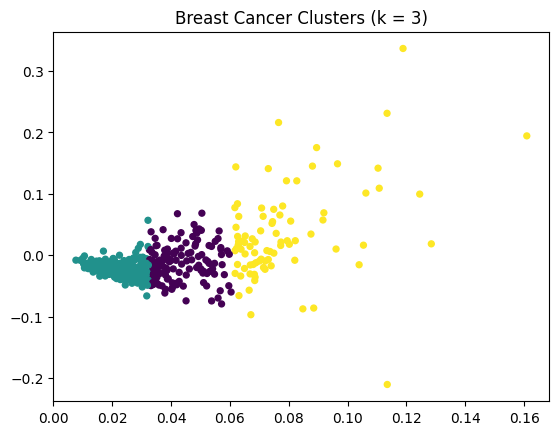

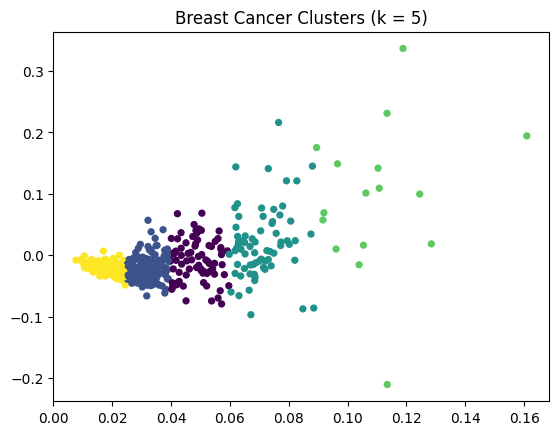

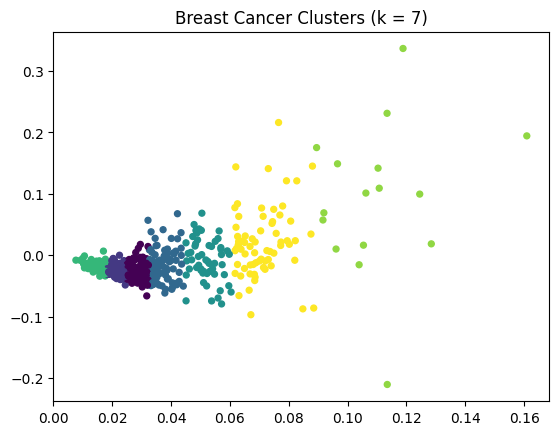

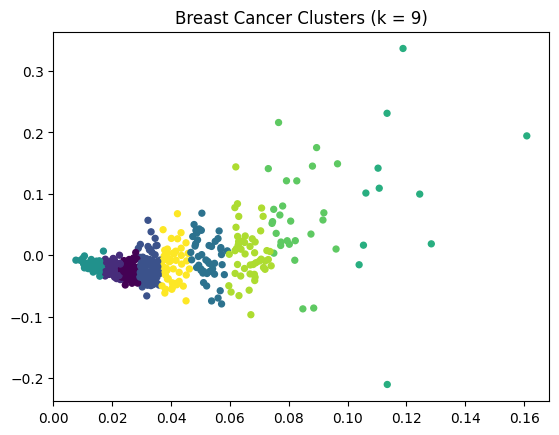

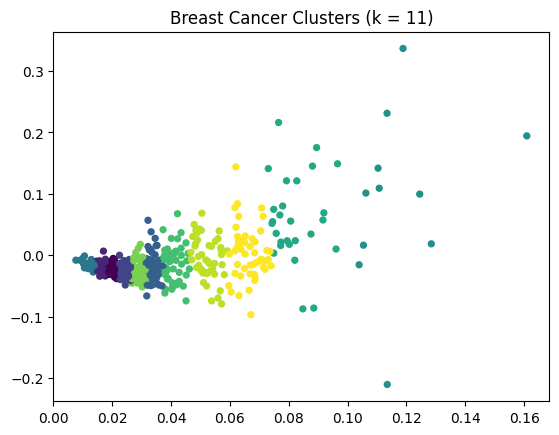

In [ ]:
# PCA for visualisation in 2D.
pca = PCA(n_components = 2)
v = pca.fit(np.transpose(X)).components_

for k in [3,5,7,9,11]:

    clusters = np.zeros(X.shape[0])

    ## STUDENT TODO START:
    kmeans = KMeans(k)
    kmeans.fit(X)

    clusters = kmeans.clusters

    ## STUDENT TODO END

    plt.scatter(v[0], v[1], c=clusters, s=18)
    plt.title("Breast Cancer Clusters (k = "+str(k) + ")")
    plt.show()

# **3. Image Classification using CNN [20 pts]**

#### **Import libraries**

In [ ]:
if NOTEBOOK:
    import os
    import numpy as np
    import pandas as pd
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    import torch.optim as optim
    from torchvision import transforms
    from torchvision.transforms import ToTensor
    from torch.utils.data import Dataset, DataLoader
    from PIL import Image
    import matplotlib.pyplot as plt

#### **Set the random seed**

In [ ]:
if NOTEBOOK:
    np.random.seed(0)
    torch.manual_seed(0)

#### **Set GPU**

In [ ]:
# Make sure you're using cuda (GPU) by checking the hardware accelerator under Runtime -> Change runtime type
if NOTEBOOK:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("We're using:", device)

We're using: cuda


#### **Download and extract the data**

In [ ]:
%%capture
if NOTEBOOK:
    !pip install -U gdown

In [ ]:
if NOTEBOOK:
    !gdown 1vacRphjb47LXifcd3F2xlsOTKR0R_LiF

Downloading...
From (original): https://drive.google.com/uc?id=1vacRphjb47LXifcd3F2xlsOTKR0R_LiF
From (redirected): https://drive.google.com/uc?id=1vacRphjb47LXifcd3F2xlsOTKR0R_LiF&confirm=t&uuid=4ce4f40f-7305-49fd-992a-7ed314662659
To: /content/supertuxkart_data.zip
100% 46.2M/46.2M [00:01<00:00, 34.7MB/s]


In [ ]:
%%capture
if NOTEBOOK:
    !yes N | unzip "/content/supertuxkart_data.zip" -d "/content"

## **3.1. Dataset class implementation**

In this section, you will be training, validating and testing a CNN model to classify images of objects from a car racing video game called SuperTuxKart. There are 6 classes of objects: kart is 1, pickup is 2, nitro is 3, bomb is 4 and projectile 5. The background class (all other images) is assigned the label 0. First, you need to load data in a way that PyTorch can deal with easily. We will lean on PyTorch’s `Dataset` class to do this.

Complete the `STKDataset` class that inherits from `Dataset`.

1. `__init__` is a constructor, and would be the natural place to perform operations common to the full dataset, such as parsing the labels and image paths.
2. The `__len__` function should return the size of the dataset, i.e., the number of samples.
3. The `__getitem__` function should return a python tuple of (image, label). The image should be a torch.Tensor of size (3, 64, 64) and the label should be an int.

The labels of the images under a particular folder (`train/` or `val/`) are stored in the same folder as `labels.csv`. Read the `labels.csv` file using `pandas` to understand what it looks like before proceeding. There is also a `labels.csv` in the `test/` folder. That would only contain the file names of the test samples.

In [ ]:
if NOTEBOOK:
    ENCODING_TO_LABELS = {0: "background",
                        1: "kart",
                        2: "pickup",
                        3: "nitro",
                        4: "bomb",
                        5: "projectile"}

    LABELS_TO_ENCODING = {"background": 0,
                        "kart": 1,
                        "pickup": 2,
                        "nitro": 3,
                        "bomb": 4,
                        "projectile": 5}

In [ ]:
if NOTEBOOK:

    class STKDataset(Dataset):

        def __init__(self, image_path, transform=None):
            self.image_path = image_path
            self.labels = pd.read_csv(image_path + "/labels.csv")
            self.transform = transform

        def __len__(self):
            ## STUDENT TODO START: Return the number of samples in the dataset
            return len(self.labels)

            ## STUDENT TODO END

        def __getitem__(self, idx):
            if torch.is_tensor(idx):
                idx = idx.tolist()

            ## STUDENT TODO START: Create the path to each image by joining the root path with the name of the file as found in labels.csv
            img_name = os.path.join(self.image_path, self.labels.iloc[idx,0])

            ## STUDENT TODO END

            # Read the image from the file path
            image = Image.open(img_name)
            # Transform the image using self.transform
            if self.transform:
                image = self.transform(image)

            if "label" in self.labels.columns:
                ## STUDENT TODO START: Extract label name and encode it using the LABELS_TO_ENCODING dictionary
                label_name = self.labels.iloc[idx,1]
                label = LABELS_TO_ENCODING.get(label_name,-1)

                ## STUDENT TODO END
                sample = (image, label)
            else:
                sample = (image)
            return sample

In [ ]:
if NOTEBOOK:
    ## STUDENT TODO START: Use transforms.Compose to transform the image such that every pixel takes on a value between -1 and 1
    # Hint: Refer to transforms.ToTensor() and transforms.Normalize()
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    ## STUDENT TODO END

    train_dataset = STKDataset(image_path="train", transform=transform)
    val_dataset = STKDataset(image_path="val", transform=transform)
    test_dataset = STKDataset(image_path="test", transform=transform)

#### **Visualization**

The following cell visualizes the data as a sanity check for your implementation of the `STKDataset` class.

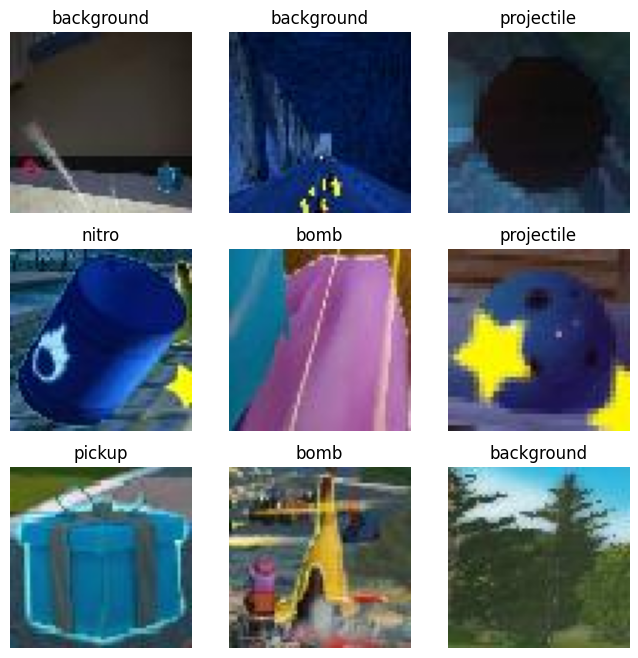

In [ ]:
if NOTEBOOK:
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    torch.manual_seed(0)
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
        img, label = train_dataset[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(ENCODING_TO_LABELS[label])
        plt.axis("off")
        plt.imshow(img.permute(1, 2, 0)*0.5 + 0.5)
    plt.show()

#### **Data loaders**

In [ ]:
if NOTEBOOK:
    ## STUDENT TODO START: Create data loaders for training, validation, and test sets each having a batch size of 64.
    # Set shuffle to be True for training and validation data loaders, False for test data loader.
    train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
    val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size = 64, shuffle = False)


    ## STUDENT TODO END

## **3.2. CNN architecture**

Your goal is to devise a CNN that passes the threshold accuracy (80%) on the test set. You get full score (20 pts) if you get at least 80% test set accuracy and 0 if you get 30% or below. The score varies linearly between 0 and 20 for accuracies between 30% and 80%.

There are several decisions that you take in building your CNN including but not limited to:

- the number of convolutional layers
- the kernel size, stride, padding and number of out channels for each convolutional layer
- number of fully connected layers
- number of nodes in each fully connected layer

You are free to decide the architecture. To make your search easier, we recommend you to use not more than four convolutional layers and four fully connected layers. We also suggest that you use the relu activation function between the layers.

In [ ]:
if NOTEBOOK:
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            ## STUDENT TODO START: Create the layers of your CNN here

            self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
            self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
            self.fc1 = nn.Linear(32 * 16 * 16, 128)
            self.fc2 = nn.Linear(128, 64)
            self.output = nn.Linear(64,6)
            self.relu = nn.ReLU()

            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)


            ## STUDENT TODO END

        def forward(self, x):
            ## STUDENT TODO START: Perform the forward pass through the layers

            x = self.pool(self.relu(self.conv1(x)))

            x = self.pool(self.relu(self.conv2(x)))

            x = x.view(-1, 32 * 16 * 16)

            x = self.relu(self.fc1(x))

            x = self.relu(self.fc2(x))

            x = self.output(x)

            return x

            ## STUDENT TODO END

    ## STUDENT TODO START: Create an instance of Net and move it to the GPU
    model = Net().to(device)

    ## STUDENT TODO END

## **3.3. Training, validation, and testing**

In [ ]:
if NOTEBOOK:
    ## STUDENT TODO START:
    # 1. Set the criterion to be cross entropy loss
    criterion = nn.CrossEntropyLoss()

    # 2. Experiment with different optimizers

    optimizer = optim.Adam(model.parameters(), lr = 0.001)

    ## STUDENT TODO END

In [ ]:
if NOTEBOOK:

    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []

    ## STUDENT TODO START:
    # Note that we have set the number of epochs to be 10. You can choose to increase or decrease the number of epochs.
    num_epochs = 10


    for epoch in range(num_epochs):

      model.train()
      total_train_loss = 0.0
      total_val_loss = 0.0
      correct_train = 0
      total_train = 0
      correct_val = 0
      total_val_loss = 0.0
      total_val = 0


      for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        y_pred = model(images)
        optimizer.zero_grad()
        loss = criterion(y_pred, labels)

        loss.backward()
        optimizer.step()

        total_train_loss+=loss.item()

        _, predicted = torch.max(y_pred, 1)
        correct_train += (predicted == labels).sum().item()
        total_train+=labels.size(0)





      model.eval()
      with torch.no_grad():
        for images, labels in val_dataloader:
          images = images.to(device)
          labels = labels.to(device)

          y_val_pred = model(images)
          loss = criterion(y_val_pred, labels)
          total_val_loss+=loss.item()

          _,predicted = torch.max(y_val_pred,1)
          correct_val += (predicted==labels).sum().item()
          total_val+=labels.size(0)





      train_loss.append(total_train_loss / len(train_loader))
      train_acc.append(100 * correct_train / total_train)
      validation_loss.append(total_val_loss / len(val_loader))
      validation_acc.append(100 * correct_val / total_val)

      print(f"Epoch {epoch+1}:")

      print(f"Training Loss:", round(train_loss[epoch], 3))
      print(f"Validation Loss:", round(validation_loss[epoch], 3))

      print(f"Training Accuracy:", round(train_acc[epoch], 3))
      print(f"Validation Accuracy:", round(validation_acc[epoch], 3))

      print("------------------------------")






    # Iterate through the epochs

        # Train the model and iterate through the training dataloader

            # 1. Store the inputs and labels in the GPU

            # 2. Get the model predictions

            # 3. Zero the gradients out

            # 4. Get the loss

            # 5. Calculate the gradients

            # 6. Update the weights

            # 7. Update the metrics

        # Append the loss and accuracy values

        # Iterate through the validation dataloader

            # 1. Store the inputs and labels in the GPU

            # 2. Get the model predictions

            # 3. Get the loss

            # 4. Update the metrics

        # Append the loss and accuracy values

        ## STUDENT TODO END


Epoch 1:
Training Loss: 0.42
Validation Loss: 0.447
Training Accuracy: 85.371
Validation Accuracy: 84.533
------------------------------
Epoch 2:
Training Loss: 0.231
Validation Loss: 0.473
Training Accuracy: 91.871
Validation Accuracy: 82.467
------------------------------
Epoch 3:
Training Loss: 0.156
Validation Loss: 0.385
Training Accuracy: 94.695
Validation Accuracy: 86.267
------------------------------
Epoch 4:
Training Loss: 0.122
Validation Loss: 0.318
Training Accuracy: 95.81
Validation Accuracy: 89.067
------------------------------
Epoch 5:
Training Loss: 0.086
Validation Loss: 0.421
Training Accuracy: 97.062
Validation Accuracy: 86.133
------------------------------
Epoch 6:
Training Loss: 0.073
Validation Loss: 0.507
Training Accuracy: 97.414
Validation Accuracy: 85.9
------------------------------
Epoch 7:
Training Loss: 0.048
Validation Loss: 0.439
Training Accuracy: 98.286
Validation Accuracy: 87.333
------------------------------
Epoch 8:
Training Loss: 0.037
Validati

In [ ]:
if NOTEBOOK:

    model.eval()

    test_predictions = np.array([])

    for i, data in enumerate(test_dataloader, 0):

        inputs = data
        ## STUDENT TODO START:
        # 1. Store the inputs in the GPU
        inputs = inputs.to(device)

        # 2. Get the model predictions
        predictions = model(inputs)

        ## STUDENT TODO END

        _, predicted = torch.max(predictions, 1)

        test_predictions = np.concatenate((test_predictions, predicted.detach().cpu().numpy()))

In [ ]:
# PennGrader Grading Cell
if NOTEBOOK:
    grader.grade(test_case_id = 'test_cnn_predictions', answer = test_predictions)

Correct! You earned 20/20 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Download the .ipynb notebook and submit on Gradescope. And, **add the manually graded parts to your written answer sheets.**

# Submit to Gradescope
Congratulations! You've finished the homework. Don't forget to submit your final notebook on [Gradescope](gradescope.com).